In [ ]:
#Libreriras y carga de datos.

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", index_col= "Person ID")
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


**Transformacion de Datos**

In [ ]:
# Renombramos las columnas con espacios para que sean compatibles con la fórmula OLS
df = df.rename(columns={
    'Sleep Duration': 'Sleep_Duration',
    'BMI Category': 'BMI_Category'
})

# Variables que usaremos
NOMBRE_VD = 'Sleep_Duration'
NOMBRE_FACTOR = 'BMI_Category'

df[NOMBRE_FACTOR] = df[NOMBRE_FACTOR].str.strip().astype('category')

In [ ]:
# En la caolumna "BMI_Category"" estan las categorias "Normal" y "Normal Weight" que es practicamente lo mismo, por lo se que usara ".replace" para dejarlas todas como "Normal Weight"

df['BMI_Category'] = df['BMI_Category'].replace('Normal', 'Normal Weight')

/tmp/ipython-input-1393451030.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['BMI_Category'] = df['BMI_Category'].replace('Normal', 'Normal Weight')


**Valores Nulos**

In [ ]:
print(df.isnull().sum())

Gender                       0
Age                          0
Occupation                   0
Sleep_Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI_Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


**Supuesto de Homogeneidad de Varianzas (Test de Levene)**

In [ ]:
# Agrupar la variable dependiente (VD) por los niveles del factor
grupos_vd = [df[df[NOMBRE_FACTOR] == grupo][NOMBRE_VD].dropna()
             for grupo in df[NOMBRE_FACTOR].unique()]

# Realizar la prueba de Levene
w, p_levene = stats.levene(*grupos_vd, center='median')

print("TEST DE LEVENE (Homogeneidad de Varianzas)")
print(f"P-valor de Levene = {p_levene:.4f}")

if p_levene > 0.05:
    print("El supuesto se cumple. Las varianzas son iguales.")
else:
    print("ADVERTENCIA: El supuesto no se cumple. Considerar el test de Welch.")

TEST DE LEVENE (Homogeneidad de Varianzas)
P-valor de Levene = 0.6055
El supuesto se cumple. Las varianzas son iguales.


**ANOVA**

In [ ]:
print("Analisis Anova")

# Definir la fórmula (VD ~ C(Factor)). 'C()' trata la variable como categórica.
formula = f'{NOMBRE_VD} ~ C({NOMBRE_FACTOR})'

modelo = ols(formula, data=df).fit()

tabla_anova = sm.stats.anova_lm(modelo, typ=2)

print(tabla_anova)

p_anova = tabla_anova.loc[f'C({NOMBRE_FACTOR})', 'PR(>F)']

Analisis Anova
                     sum_sq     df          F        PR(>F)
C(BMI_Category)   33.813080    2.0  31.001719  3.545814e-13
Residual         202.321893  371.0        NaN           NaN


**Post Hoc (Tukey HSD)**

In [ ]:

if p_anova < 0.05:
    print(f"ANOVA significativo (p = {p_anova:.4f}). Realizando Tukey HSD...")

    # 1. Ejecutar la prueba Tukey HSD
    posthoc = pairwise_tukeyhsd(
        endog=df[NOMBRE_VD],      # Variable Dependiente
        groups=df[NOMBRE_FACTOR], # Factor
        alpha=0.05                # Nivel de significancia
    )

    print(posthoc)

    # Interpretación: La columna 'reject' = True indica una diferencia significativa entre el par.
else:
    print(f"ANOVA no significativo (p = {p_anova:.4f}). No se requieren pruebas Post Hoc.")

print("\nLos resultados Post Hoc identifican qué pares de grupos difieren.")

ANOVA significativo (p = 0.0000). Realizando Tukey HSD...
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1      group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
Normal Weight      Obese   -0.428 0.1738 -0.9901  0.1341  False
Normal Weight Overweight  -0.6177    0.0 -0.8031 -0.4323   True
        Obese Overweight  -0.1897 0.7117 -0.7575  0.3781  False
---------------------------------------------------------------

Los resultados Post Hoc identifican qué pares de grupos difieren.


**Grafico Boxplot**

/tmp/ipython-input-2306911511.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = df.groupby('BMI_Category')['Sleep_Duration'].mean().sort_values(ascending=False).index
/tmp/ipython-input-2306911511.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



Nota: El gráfico se genera en la salida de tu entorno Python.
Las diferencias significativas se encontraron entre Normal/Normal Weight y Overweight.


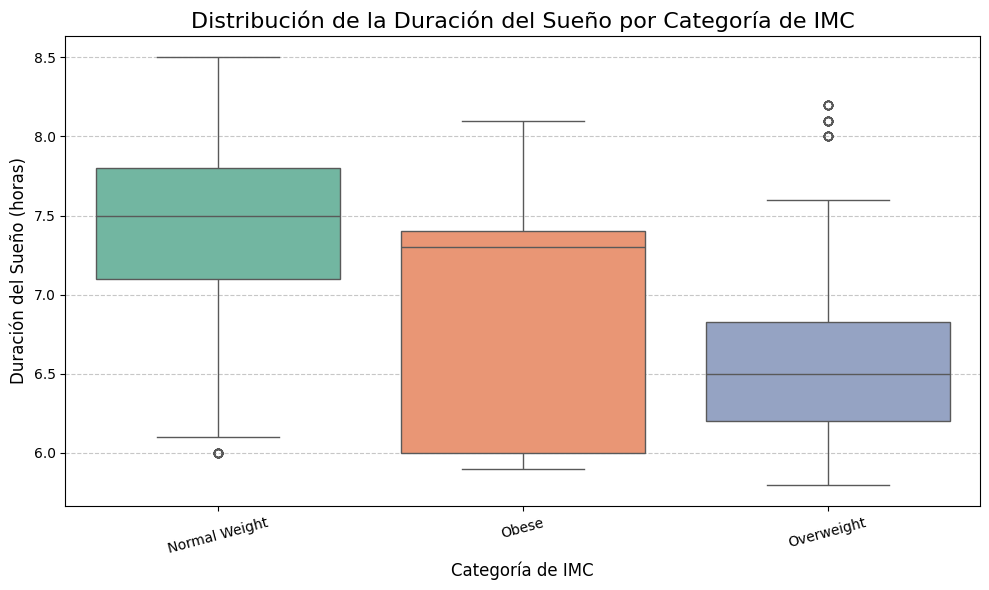

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

order = df.groupby('BMI_Category')['Sleep_Duration'].mean().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))

# Generar el Boxplot
sns.boxplot(
    x='BMI_Category',
    y='Sleep_Duration',
    data=df,
    order=order,
    palette='Set2'
)


plt.title('Distribución de la Duración del Sueño por Categoría de IMC', fontsize=16)
plt.xlabel('Categoría de IMC', fontsize=12)
plt.ylabel('Duración del Sueño (horas)', fontsize=12)
plt.xticks(rotation=15)

print("\nNota: El gráfico se genera en la salida de tu entorno Python.")
print("Las diferencias significativas se encontraron entre Normal/Normal Weight y Overweight.")

# Mostrar el gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Interpretacion del Grafico Boxplot**


***Mediana***

Diferencia de Grupos: Las cajas de Normal y Normal Weight están visiblemente ubicadas en la parte superior del gráfico, indicando que estos grupos tienen la mediana más alta (mayor duración del sueño).

Grupo de Menor Sueño: La caja de la categoría Overweight está notablemente más baja que la de Normal y Normal Weight. Esto confirma que este grupo tiene una mediana significativamente menor en la duración del sueño, lo cual fue identificado como estadísticamente significativo por la prueba de Tukey.


***Dispersion y Variabilidad***

Si la caja del grupo Obese o Overweight es más ancha (más alta en el eje Y), significa que la variabilidad (dispersión de la duración del sueño) es mayor en ese grupo. En otras palabras, hay una mayor heterogeneidad entre los individuos de esa categoría respecto a cuánto duermen. Si las cajas de Normal y Normal Weight son más estrechas, sugiere que las personas en estos grupos tienen duraciones de sueño más consistentes.






**Preparacion para ML**

In [ ]:
from sklearn.model_selection import train_test_split

# Seleccionar variables numéricas relevantes
features = ["Sleep_Duration", "Physical Activity Level", "Stress Level",
            "Heart Rate", "Daily Steps", "Age"]
target = "Quality of Sleep"

X = df[features]
y = df[target]

# Dividir en train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**Árbol de Decisión**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Entrenar árbol de decisión
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# Predicciones
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

# Métricas
print("Árbol de Decisión")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_tree)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_tree)))
print("Train R2:", r2_score(y_train, y_train_pred_tree))
print("Test R2:", r2_score(y_test, y_test_pred_tree))


Árbol de Decisión
Train RMSE: 0.0
Test RMSE: 0.0
Train R2: 1.0
Test R2: 1.0


**Grafico de Profundidad del Arbol**

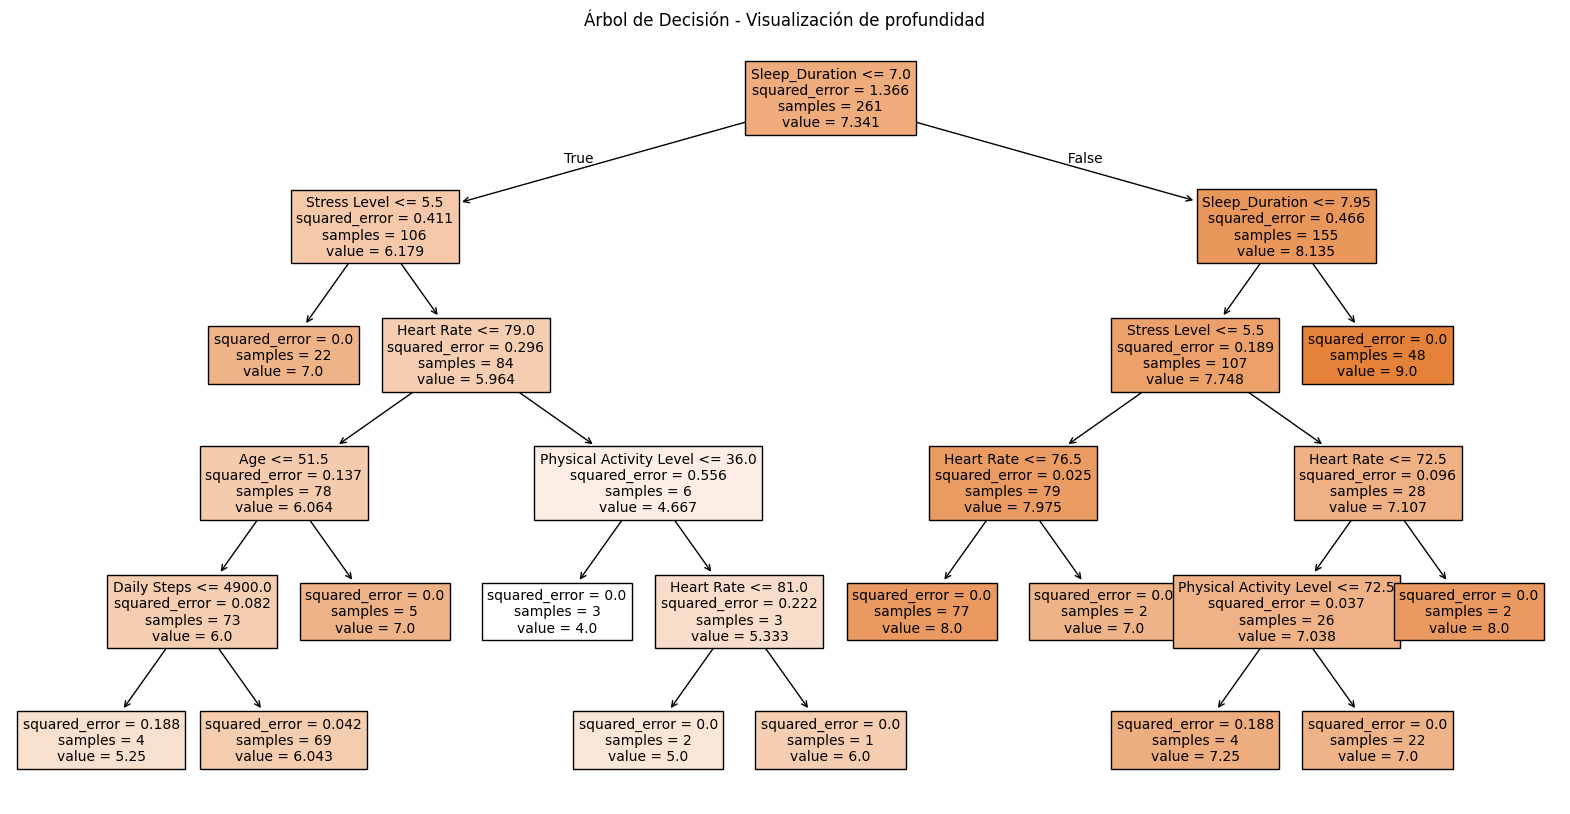

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

tree = DecisionTreeRegressor(random_state=42, max_depth=5)
tree.fit(X_train, y_train)

# Visualizar el árbol
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=features, filled=True, fontsize=10)
plt.title("Árbol de Decisión - Visualización de profundidad")
plt.show()


**Conclusion**

En entrenamiento: R² muy alto, RMSE muy bajo casi perfecto, caída significativa en métricas (overfitting). El árbol captura patrones complejos y específicos del dataset, tiene bajo bias (aprende mucho de los datos), pero alta varianza (no generaliza bien).

Necesita regularización (ej. limitar profundidad, usar Random Forest) para reducir varianza y mejorar generalización.

**Regresion Lineal**

In [ ]:
from sklearn.linear_model import LinearRegression

# Entrenar regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones
y_train_pred_lr = lin_reg.predict(X_train)
y_test_pred_lr = lin_reg.predict(X_test)

# Métricas
print("Regresión Lineal")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print("Train R2:", r2_score(y_train, y_train_pred_lr))
print("Test R2:", r2_score(y_test, y_test_pred_lr))


Regresión Lineal
Train RMSE: 0.3663437229796117
Test RMSE: 0.3538097289852145
Train R2: 0.901785828981226
Test R2: 0.9201099395091612


**Grafico Regresion Lineal**

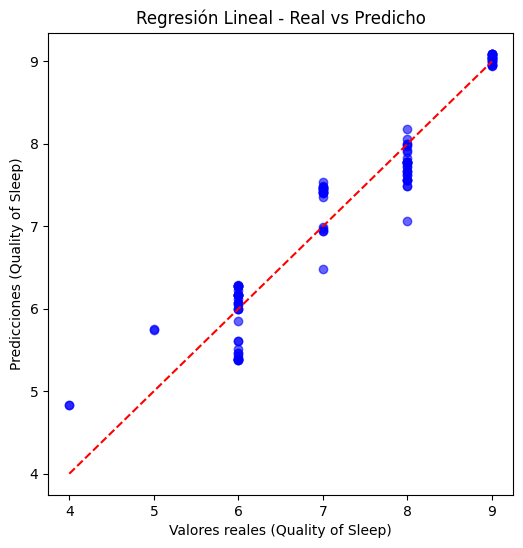

In [ ]:
# Gráfico: valores reales vs predicciones en test
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_lr, color="blue", alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Valores reales (Quality of Sleep)")
plt.ylabel("Predicciones (Quality of Sleep)")
plt.title("Regresión Lineal - Real vs Predicho")
plt.show()

**Conclusion**

RMSE y R² similares en ambos conjuntos, no muestra una caída fuerte en test (generaliza bien). El modelo es simple, capta relaciones lineales entre variables y la calidad del sueño. Tiene alto bias (no captura patrones complejos), pero baja varianza (estable entre train/test).
Es un modelo robusto para generalización, aunque puede perder precisión en casos donde las relaciones no sean lineales.

**PCA**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA con 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Cargas de los componentes
loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1", "PC2"])
print("\nCargas PCA")
print(loadings)



Cargas PCA
                              PC1       PC2
Sleep_Duration          -0.547719  0.043543
Physical Activity Level -0.073455  0.699502
Stress Level             0.585963  0.097907
Heart Rate               0.474718  0.105537
Daily Steps              0.025161  0.684505
Age                     -0.353928  0.139750


**Grafico PCA**

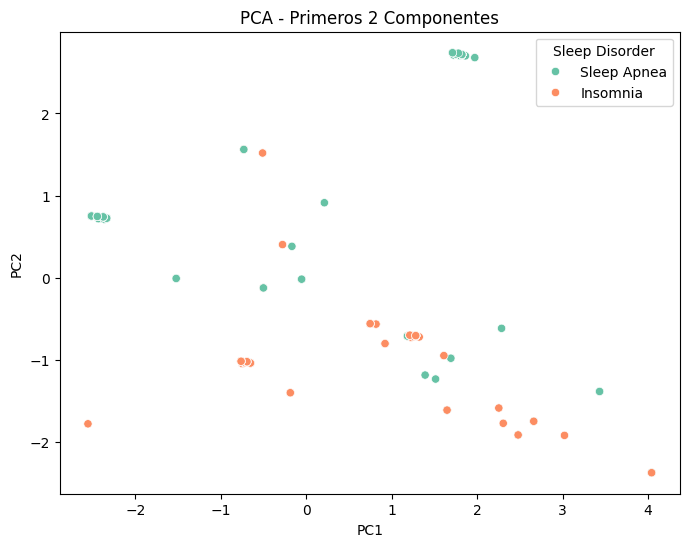

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico PCA por trastorno del sueño
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["Sleep Disorder"], palette="Set2")
plt.title("PCA - Primeros 2 Componentes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Sleep Disorder")
plt.show()


**Conclusion PCA**

PC1: Physical Activity Level y Daily Steps, representan principalmente el nivel de actividad física.

PC2: Stress Level y Sleep Duration, representan el balance entre estrés y duración del sueño.

Los dos primeros componentes explican gran parte de la variabilidad.Las variables más relevantes para diferenciar patrones de sueño son actividad física, pasos diarios, nivel de estrés y duración del sueño. PCA confirma que la calidad del sueño está más influenciada por hábitos de actividad y estrés que por edad o frecuencia cardíaca.



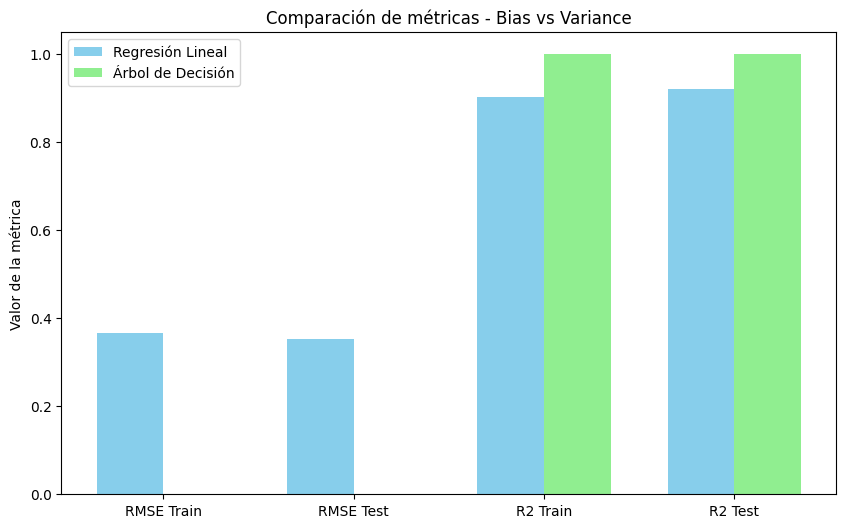

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
rmse_test_lr  = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
r2_train_lr   = r2_score(y_train, y_train_pred_lr)
r2_test_lr    = r2_score(y_test, y_test_pred_lr)

rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
rmse_test_tree  = np.sqrt(mean_squared_error(y_test, y_test_pred_tree))
r2_train_tree   = r2_score(y_train, y_train_pred_tree)
r2_test_tree    = r2_score(y_test, y_test_pred_tree)

metrics = ["RMSE Train", "RMSE Test", "R2 Train", "R2 Test"]
lr_values = [rmse_train_lr, rmse_test_lr, r2_train_lr, r2_test_lr]
tree_values = [rmse_train_tree, rmse_test_tree, r2_train_tree, r2_test_tree]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, lr_values, width, label="Regresión Lineal", color="skyblue")
plt.bar(x + width/2, tree_values, width, label="Árbol de Decisión", color="lightgreen")

plt.xticks(x, metrics)
plt.ylabel("Valor de la métrica")
plt.title("Comparación de métricas - Bias vs Variance")
plt.legend()
plt.show()


**Interpretacion del Grafico**

*RMSE Train/Test:*

Si el árbol tiene RMSE muy bajo en train pero alto en test, overfitting.

La regresión suele tener valores más cercanos, bias alto pero varianza baja.



*R² Train/Test:*

Árbol: R² casi perfecto en train pero caída en test, alta varianza.

Regresión: R² más bajo en train pero estable en test, bias alto, varianza baja.

**Trade-off Bias-Variance**

*Regresión Lineal*

Bias alto, simplifica demasiado las relaciones, varianza baja, estable entre train/test. modelo conservador, menos preciso pero más confiable para generalizar.

*Árbol de Decisión*

Bias bajo, aprende patrones complejos. varianza alta, se ajusta demasiado al train y falla en test. modelo flexible pero con riesgo de sobreajuste.

El trade-off se ve claramente, si se busca estabilidad y generalización, la regresión lineal es mejor. Caso contrario si busca precisión en entrenamiento y relaciones complejas, el árbol es más potente, pero requiere control de varianza.

**Interpretación final**

La regresión lineal es un buen punto de partida para generalización.

El árbol de decisión necesita regularización para evitar overfitting.

PCA muestra que los factores más relevantes para explicar la variabilidad en la calidad del sueño son actividad física, pasos diarios, nivel de estrés y duración del sueño.